# Denoising

Philippe Massouf
Diego Torres

In [ ]:
import numpy as np
import pandas as pd

from scipy.io.wavfile import read
from scipy.fft import fft, ifft, fftfreq, fftshift
from scipy.signal import welch, convolve2d

import matplotlib.pyplot as plt

In [ ]:
sr, noise1 = read('noise1.wav')
sr, noise2 = read('noise2.wav')
sr, noise3 = read('noise3.wav')

In [ ]:
def plot_figures(noise):
    periodogram  = fft(noise)
    freq = fftfreq(noise.shape[0], 1/sr)
    freqs, power = welch(noise, fs=sr, nperseg=1024)

    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 10))
    
    ax1.plot(noise)
    ax1.set_xlabel('Time (frame)')
    ax1.set_ylabel('Amplitude')
    ax1.set_title('Time domain')


    ax2.plot(freq[:len(freq)//2], 20*np.log(np.abs(periodogram[:len(periodogram)//2])))
    ax2.set_xscale('log')
    ax2.set_xlabel('Frequency (Hz)')
    ax2.set_ylabel('Power (dB)')


    ax3.plot(freqs, 10*np.log(power))
    ax3.set_xlabel('Frequency (Hz)')
    ax3.set_xscale('log')
    ax3.set_ylabel('Power (dB)')

    return freqs, power


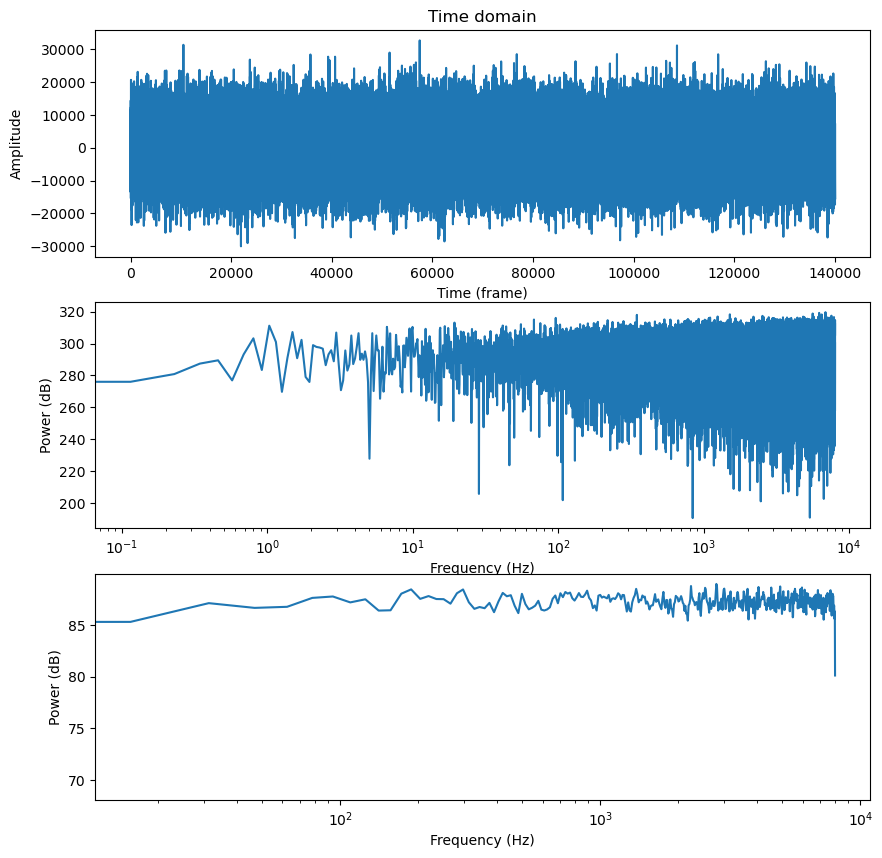

In [ ]:
freqs, noise1_power = plot_figures(noise1)

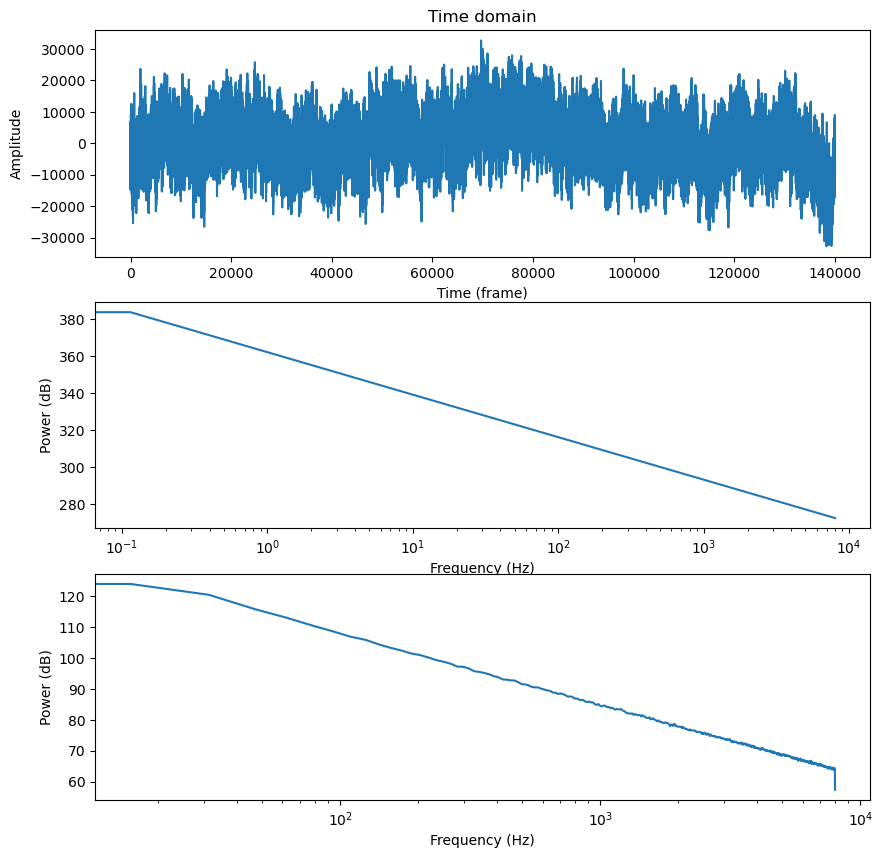

In [ ]:
freqs, noise2_power = plot_figures(noise2)

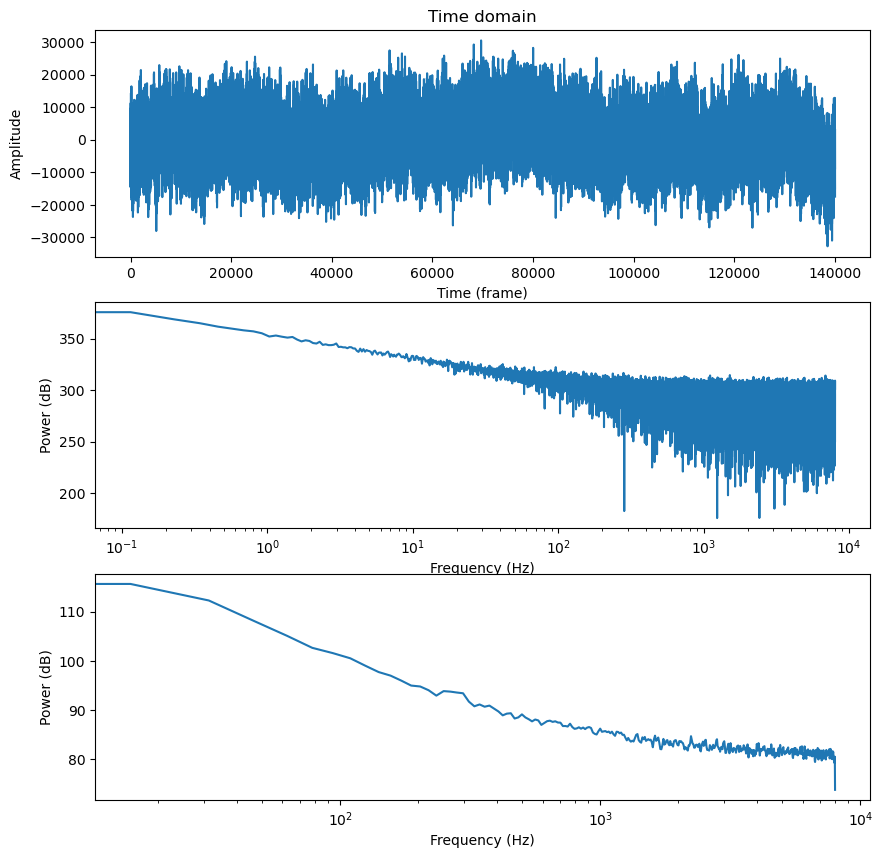

In [ ]:
freqs, noise3_power = plot_figures(noise3)

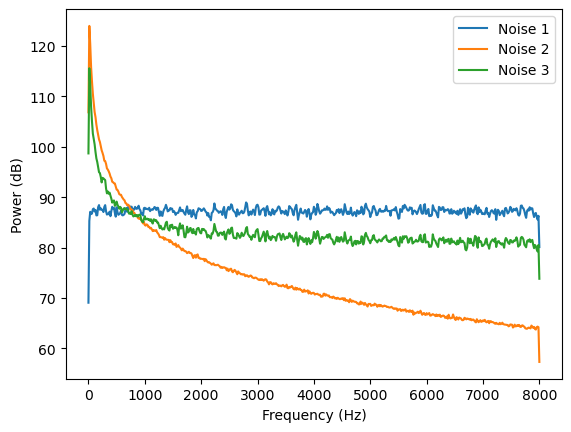

In [ ]:
plt.plot(freqs, 10*np.log(noise1_power), label='Noise 1')
plt.plot(freqs, 10*np.log(noise2_power), label='Noise 2')
plt.plot(freqs, 10*np.log(noise3_power), label='Noise 3')
# plt.xscale('log')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power (dB)')

plt.legend()

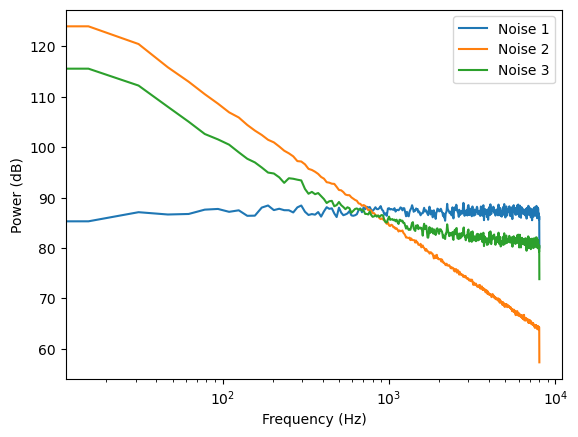

In [ ]:
plt.plot(freqs, 10*np.log(noise1_power), label='Noise 1')
plt.plot(freqs, 10*np.log(noise2_power), label='Noise 2')
plt.plot(freqs, 10*np.log(noise3_power), label='Noise 3')
plt.xscale('log')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power (dB)')

plt.legend()